In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kruskal, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
# CNNs
df_cnn = pd.DataFrame({
    'Algorithm': ['redcnn','redcnn+','sacnn','magic','magic-semi','bioatt'],
    'SSIM': [0.9812,0.9825,0.78,0.9460,0.9425,0.7161],
    'PSNR': [44.8947,45.1584,22.1758,34.18,33.70,29.30],
    'RMSE': [0.0058,0.0056,0.078,0.0195,0.0207,0.0391],
    'Dataset': ['NBIA','NBIA','Mayo Clinic','Mayo Clinic','Mayo Clinic','Mayo Clinic'],
})

# Transformers
df_trans = pd.DataFrame({
    'Algorithm': ['ctlformer','hcformer','tednet','eformer'],
    'SSIM': [0.9141,0.8507,0.9144,0.9861],
    'PSNR': [29,47.28,29.27,43.487],
    'RMSE': [0.0354,0.0695,0.034385,0.0067],
    'Dataset': ['Mayo Clinic','Mayo Clinic','Mayo Clinic','Mayo Clinic'],
})

# GANs
df_gan = pd.DataFrame({
    'Algorithm': ['wgan','dugan','dugan_25','cycle gan'],
    'SSIM': [0.6949,0.7489,0.9196,0.89744],
    'PSNR': [22.162,22.3075,34.6186,36.068],
    'RMSE': [0.08691,0.0802,0.0196,0.015725],
    'Dataset': ['Mayo Clinic','Mayo Clinic','Mayo Clinic','Unknown'],
})

# Diffusion Models
df_diff = pd.DataFrame({
    'Algorithm': ['corediff','founddiff'],
    'SSIM': [0.8107,0.9731],
    'PSNR': [34.13,44.22],
    'RMSE': [0.1835,0.0062],
    'Dataset': ['Mayo Clinic','Mayo Clinic']
})

# Misc Models
df_misc = pd.DataFrame({
    'Algorithm': ['sinogram flicking','learned primal dual','noise2inverse','ran2i','idolnet'],
    'SSIM': [0.7362,0.989,0.99,0.94,0.9858],
    'PSNR': [34.77,38.28,45.06,38.37,40.2],
    'RMSE': [0.0184,0.0122,0.0056,0.0121,0.0098],
    'Dataset': ['Sinogram','Sinogram','Sinogram','Sinogram','DeepLesion'],
})

In [7]:
dfs = {'CNN': df_cnn, 'Transformers': df_trans, 'GANs': df_gan, 'Diffusion': df_diff, 'Miscellaneous': df_misc}
all_dfs = []
for fam, df in dfs.items():
    tmp = df.copy()
    tmp['Family'] = fam
    all_dfs.append(tmp)

df_all = pd.concat(all_dfs, ignore_index=True)
print(f"Total algorithms: {len(df_all)}")
print(f"Families: {df_all['Family'].unique()}")
print(f"Datasets: {df_all['Dataset'].unique()}")

Total algorithms: 21
Families: ['CNN' 'Transformers' 'GANs' 'Diffusion' 'Miscellaneous']
Datasets: ['NBIA' 'Mayo Clinic' 'Unknown' 'Sinogram' 'DeepLesion']


# Performance ranking

Normalise scores and assign ranks for comparabilty.

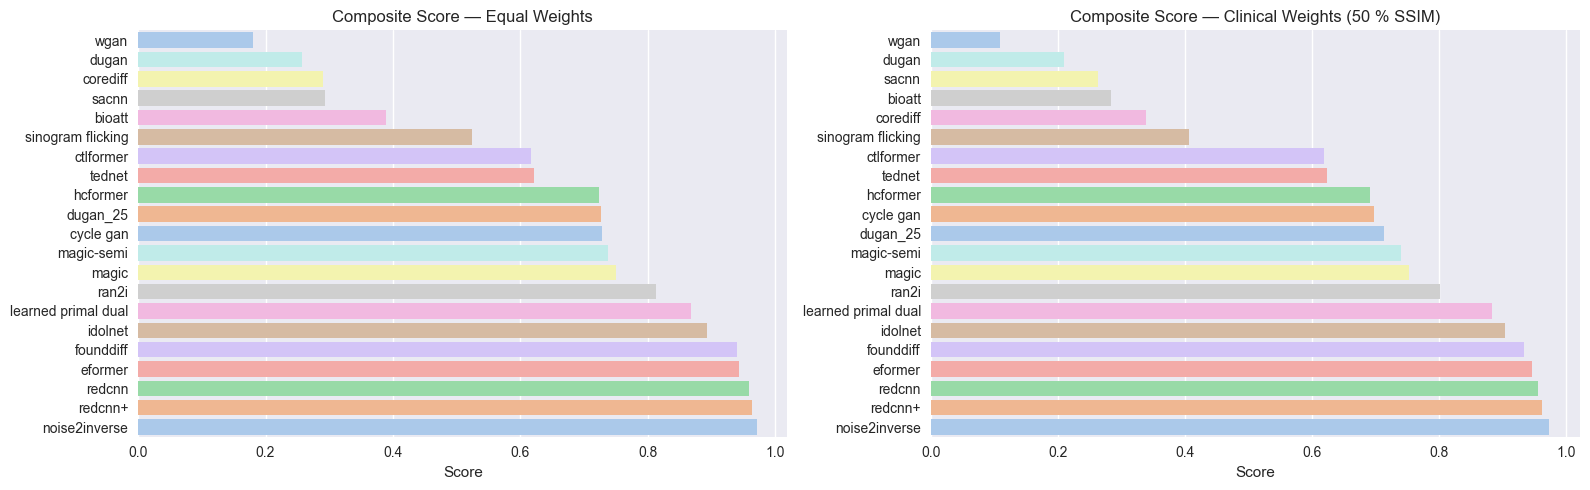

In [12]:
import os
os.makedirs("figures", exist_ok=True)

scaler = MinMaxScaler()
df_all['SSIM_norm'] = scaler.fit_transform(df_all[['SSIM']])
df_all['PSNR_norm'] = scaler.fit_transform(df_all[['PSNR']])
df_all['RMSE_norm'] = 1 - scaler.fit_transform(df_all[['RMSE']])  

df_all['Composite_Equal'] = (
    df_all['SSIM_norm'] + df_all['PSNR_norm'] + df_all['RMSE_norm']
) / 3

df_all['Composite_Clinical'] = (
      0.5 * df_all['SSIM_norm']
    + 0.3 * df_all['PSNR_norm']
    + 0.2 * df_all['RMSE_norm']
)

equal_sorted     = df_all.sort_values('Composite_Equal',     ascending=False)
clinical_sorted  = df_all.sort_values('Composite_Clinical',  ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(
    data=equal_sorted,
    y='Algorithm', x='Composite_Equal',
    palette=sns.color_palette('pastel', n_colors=len(equal_sorted)),
    ax=axes[0]
)
axes[0].set_title('Composite Score — Equal Weights')
axes[0].set_xlabel('Score'); axes[0].set_ylabel('')
axes[0].invert_yaxis()

sns.barplot(
    data=clinical_sorted,
    y='Algorithm', x='Composite_Clinical',
    palette=sns.color_palette('pastel', n_colors=len(clinical_sorted)),
    ax=axes[1]
)
axes[1].set_title('Composite Score — Clinical Weights (50 % SSIM)')
axes[1].set_xlabel('Score'); axes[1].set_ylabel('')
axes[1].invert_yaxis()

plt.tight_layout()

outpath = "figures/composite_scores.png"
fig.savefig(outpath, bbox_inches='tight', dpi=300)

plt.show()

## Analysis of Algorithm Performance

Based on the composite scores calculated using equal and clinical weighting schemes, and the ranked table of algorithms, the following observations can be made:

**Family Representation in Top Ranks:**
The top ranks are primarily occupied by algorithms from the 'Misc' and 'CNN' families. Notable algorithms from 'Misc' include 'noise2inverse', 'learned primal dual', and 'ran2i', while 'redcnn+', 'redcnn', 'magic', and 'magic-semi' are strong performers from the 'CNN' family. Algorithms from 'Transformers' ('eformer') and 'Diffusion' ('founddiff') also feature in the top ranks. The 'GANs' family has some representation in the top algorithms as well.

**Weight Sensitivity:**
The algorithm rankings show some sensitivity to the weighting scheme. While the top few algorithms remain consistent, the relative positions of others change when clinical weights (prioritizing SSIM) are applied. This highlights the importance of considering the specific performance metrics most relevant to the application.

**Performance Gaps:**
There isn't a distinct gap separating the top algorithms from the rest. Instead, there's a gradual decrease in performance scores. The leading algorithms do form a high-performing cluster, but several other algorithms follow closely, suggesting a competitive landscape rather than a few clear outliers in performance.

In [37]:
import dataframe_image as dfi

In [ ]:
ranking = df_all[['Algorithm', 'Family', 'SSIM', 'PSNR', 'RMSE', 'Composite_Equal', 'Composite_Clinical']].copy()
ranking = ranking.sort_values('Composite_Equal', ascending=False).reset_index(drop=True)
ranking['Rank'] = ranking.index + 1

def color_rank(val):
    if val <= 3:
        return 'background-color: #90EE90'  # Light green
    elif val <= 7:
        return 'background-color: #FFE4B5'  # Light yellow
    else:
        return 'background-color: #FFB6C1'  # Light red

styled_ranking = ranking.head(10).style.applymap(color_rank, subset=['Rank'])
display(styled_ranking)
os.makedirs("tables", exist_ok=True)

dfi.export(styled_ranking, 'tables/ranking_table.png', table_conversion="matplotlib")

,Algorithm,Family,SSIM,PSNR,RMSE,Composite_Equal,Composite_Clinical,Rank
0,noise2inverse,Miscellaneous,0.990000,45.060000,0.005600,0.970539,0.973485,1
1,redcnn+,CNN,0.982500,45.158400,0.005600,0.963373,0.961953,2
2,redcnn,CNN,0.981200,44.894700,0.005800,0.958031,0.956376,3
3,eformer,Transformers,0.986100,43.487000,0.006700,0.943198,0.946853,4
4,founddiff,Diffusion,0.973100,44.220000,0.006200,0.939178,0.934144,5
5,idolnet,Miscellaneous,0.985800,40.200000,0.009800,0.893430,0.903601,6
6,learned primal dual,Miscellaneous,0.989000,38.280000,0.012200,0.867068,0.883393,7
7,ran2i,Miscellaneous,0.940000,38.370000,0.012100,0.813101,0.801558,8
8,magic,CNN,0.946000,34.180000,0.019500,0.750409,0.753361,9
9,magic-semi,CNN,0.942500,33.700000,0.020700,0.737837,0.740349,10


# Performance statistics

Calculate the mean, median and deviation of metrics across all algorithms and compare.

In [18]:
import dataframe_image as dfi

In [ ]:
family_stats = df_all.groupby('Family').agg({
    'SSIM': ['count', 'mean', 'std', 'min', 'max'],
    'PSNR': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'Composite_Equal': ['mean', 'std']
}).round(4)

family_stats.columns = ['_'.join(col).strip() for col in family_stats.columns]

styled_family_stats = family_stats.style.highlight_max(subset=['SSIM_mean', 'SSIM_min', 'SSIM_max',
                                                            'PSNR_mean', 'PSNR_min', 'PSNR_max',
                                                            'RMSE_min', 'RMSE_max', 
                                                            'Composite_Equal_mean'], color='lightgreen')\
                                        .highlight_min(subset=['RMSE_mean', 'RMSE_min', 'RMSE_max',
                                                            'SSIM_mean', 'SSIM_min', 'SSIM_max',
                                                            'PSNR_mean', 'PSNR_min', 'PSNR_max',
                                                            'Composite_Equal_mean'], color='salmon')\
                                        .highlight_min(subset=['SSIM_std', 'PSNR_std', 'RMSE_std', 'Composite_Equal_std'], color='yellow') 

dfi.export(styled_family_stats, 'tables/family_stats.png', table_conversion="matplotlib")
display(styled_family_stats)

,SSIM_count,SSIM_mean,SSIM_std,SSIM_min,SSIM_max,PSNR_mean,PSNR_std,PSNR_min,PSNR_max,RMSE_mean,RMSE_std,RMSE_min,RMSE_max,Composite_Equal_mean,Composite_Equal_std
Family,,,,,,,,,,,,,,,
CNN,6,0.891400,0.114100,0.716100,0.982500,34.901500,8.948200,22.175800,45.158400,0.028100,0.027400,0.005600,0.078000,0.682100,0.282600
Diffusion,2,0.891900,0.114800,0.810700,0.973100,39.175000,7.134700,34.130000,44.220000,0.094800,0.125400,0.006200,0.183500,0.614400,0.459300
GANs,4,0.815200,0.110300,0.694900,0.919600,28.789000,7.591600,22.162000,36.068000,0.050600,0.038200,0.015700,0.086900,0.472800,0.295000
Miscellaneous,5,0.928200,0.109400,0.736200,0.990000,39.336000,3.755200,34.770000,45.060000,0.011600,0.004600,0.005600,0.018400,0.813500,0.171800
Transformers,4,0.916300,0.055300,0.850700,0.986100,37.259200,9.508700,29.000000,47.280000,0.036500,0.025700,0.006700,0.069500,0.725900,0.153000


## Analysis of Algorithm Family Statistics

The table of family statistics provides insights into the average performance and variability of different algorithm families across the evaluated metrics.

**Key Observations:**

*   **Overall Composite Score:** The 'Misc' family has the highest average 'Composite_Equal' score (0.8135), indicating the strongest overall performance when all metrics are weighted equally. The 'Transformers' and 'CNN' families follow with average scores of 0.7259 and 0.6821, respectively. The 'GANs' family has the lowest average composite score (0.4728).
*   **SSIM:** The 'Misc' family shows the highest average SSIM (0.9282), suggesting its algorithms are generally best at preserving structural similarity. 'Transformers' and 'CNN' also have high average SSIMs. The 'GANs' family has the lowest average SSIM (0.8152).
*   **PSNR:** The 'Misc' family also leads in average PSNR (39.3360), indicating better performance in minimizing pixel-wise differences. 'Diffusion' and 'Transformers' have the next highest average PSNRs. The 'GANs' family has the lowest average PSNR (28.7890).
*   **RMSE:** The 'Misc' family has the lowest average RMSE (0.0116), which is desirable as lower RMSE indicates less error. The 'Transformers' and 'CNN' families have higher average RMSEs. The 'Diffusion' family has the highest average RMSE (0.09485).
*   **Consistency (Standard Deviation):** The 'Misc' family generally exhibits lower standard deviations across SSIM, PSNR, and RMSE compared to other families, suggesting more consistent performance among its algorithms for these metrics. The 'Diffusion' and 'GANs' families show higher variability in some metrics.

In summary, the 'Misc' family appears to be the strongest and most consistent performer on average across the evaluated metrics, followed by 'Transformers' and 'CNNs'. The 'GANs' family generally shows the lowest average performance across SSIM and PSNR, while 'Diffusion' has the highest average RMSE. However, the variability within families is important to consider, as some individual algorithms within families with lower average scores might still perform very well.

### Explanation of Table Highlighting Colors

In the family statistics table, the colors are used to highlight key performance indicators:

*   **Green:** Indicates the best performance for a given metric. For SSIM, PSNR, and Composite Equal, this is the **highest** value. For RMSE (where lower is better), this is the **lowest** value.
*   **Red:** Indicates the worst performance for a given metric. For SSIM, PSNR, and Composite Equal, this is the **lowest** value. For RMSE, this is the **highest** value.
*   **Yellow:** Indicates the **minimum standard deviation** for each metric, suggesting the most consistent performance within that family for that metric.

# Performance distribution visualization

Visualize the distribution of performance metrics within each family using box plots to understand the spread and central tendency of each metric per family.


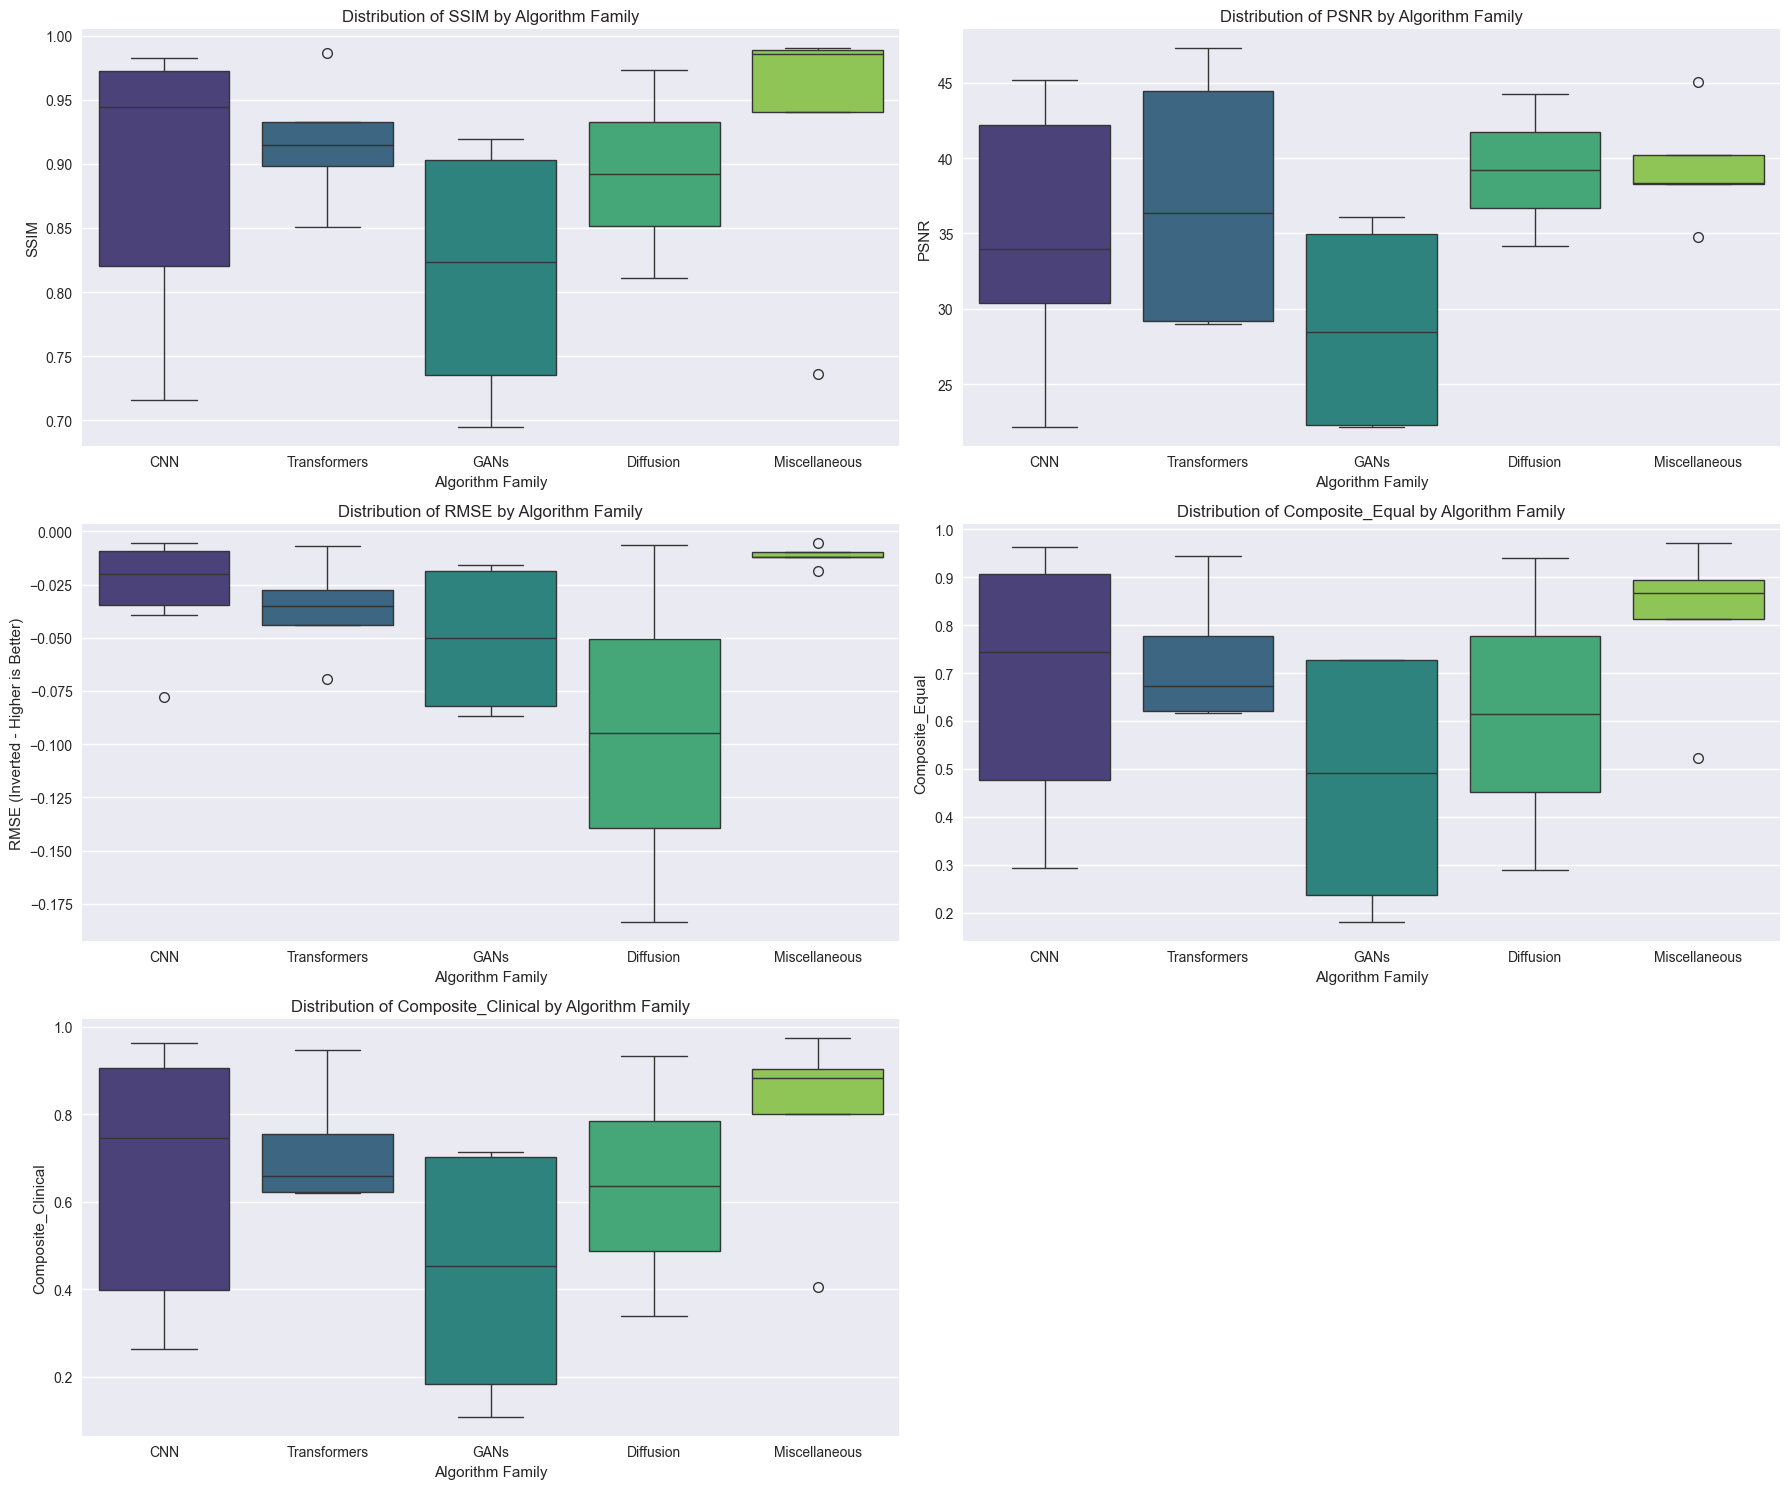

In [23]:
metrics_to_plot = ['SSIM', 'PSNR', 'RMSE', 'Composite_Equal', 'Composite_Clinical']
n_metrics = len(metrics_to_plot)

fig = plt.figure(figsize=(18, 5 * ((n_metrics + 1) // 2)))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot((n_metrics + 1) // 2, 2, i + 1)
    plot_data = df_all.copy()
    ylabel = metric

    if metric == 'RMSE':
        plot_data[metric] = plot_data[metric] * -1
        ylabel = 'RMSE (Inverted - Higher is Better)'

    sns.boxplot(data=plot_data, x='Family', y=metric, palette='viridis')
    plt.title(f'Distribution of {metric} by Algorithm Family')
    plt.xlabel('Algorithm Family')
    plt.ylabel(ylabel)

plt.tight_layout()
fig.savefig("figures/family_boxplots.png", bbox_inches='tight', dpi=300)
plt.show()

## Analysis of Performance Distribution (Box Plots)

The box plots visualizing the distribution of performance metrics within each algorithm family provide a detailed view of their central tendency, variability, and potential outliers.

*   **SSIM Distribution:** The SSIM box plot for the 'Misc' family is characterized by a high median and a very short box (interquartile range), indicating consistently high SSIM values with minimal variability. The whiskers are also short, suggesting that most algorithms in this family perform within a narrow, high range. 'CNN' and 'Transformers' families show higher median SSIMs than 'GANs' and 'Diffusion', but with larger boxes and longer whiskers, reflecting greater variability. The 'GANs' and 'Diffusion' families have lower median SSIMs and wider distributions, with some potential outliers visible as individual points beyond the whiskers.

*   **PSNR Distribution:** The PSNR box plot shows that 'Misc' and 'Transformers' families have high medians and relatively compact boxes, signifying good average PSNR with less spread. The 'GANs' family has the lowest median PSNR and the largest box, indicating the lowest average performance and highest variability. The 'CNN' and 'Diffusion' families show intermediate PSNR performance and variability. Outliers are visible in the 'GANs' and 'Diffusion' families.

*   **RMSE Distribution (Inverted):** On the inverted RMSE plot, the 'Misc' family exhibits a high median and a very small box and short whiskers, indicating consistently low actual RMSE values. This highlights the robustness of algorithms in this family in minimizing error. The 'Diffusion' family, in contrast, has a low median inverted RMSE and a very large box and long whiskers, demonstrating high actual RMSE values and substantial variability. Outliers with very high actual RMSE are evident in the 'Diffusion' family.

*   **Composite Score Distributions:** The box plots for both composite scores clearly show the 'Misc' family with the highest medians and the smallest boxes, reinforcing their superior average performance and consistency. The 'GANs' family consistently has the lowest medians and relatively large boxes, indicating weaker average performance and higher variability. The distributions of 'CNN', 'Transformers', and 'Diffusion' fall between 'Misc' and 'GANs'.

In summary, the box plots provide compelling visual evidence of the 'Misc' family's strong and consistent performance across the key evaluation metrics. They also effectively illustrate the performance range and variability within other families, identifying potential areas of strength and weakness.

# Correlation Analysis of Performance Metrics

Investigate the relationships between the performance metrics (SSIM, PSNR, and RMSE) by calculating and visualizing the correlation matrix.
Understanding the correlations between metrics helps to determine if they provide independent information about algorithm performance or if they are highly related. For example, if SSIM and PSNR are highly correlated, algorithms that perform well on one metric are likely to perform well on the other. This analysis is relevant for selecting appropriate evaluation metrics and interpreting overall performance.

,SSIM,PSNR,RMSE
SSIM,1.000000,0.710133,-0.621088
PSNR,0.710133,1.000000,-0.469617
RMSE,-0.621088,-0.469617,1.000000


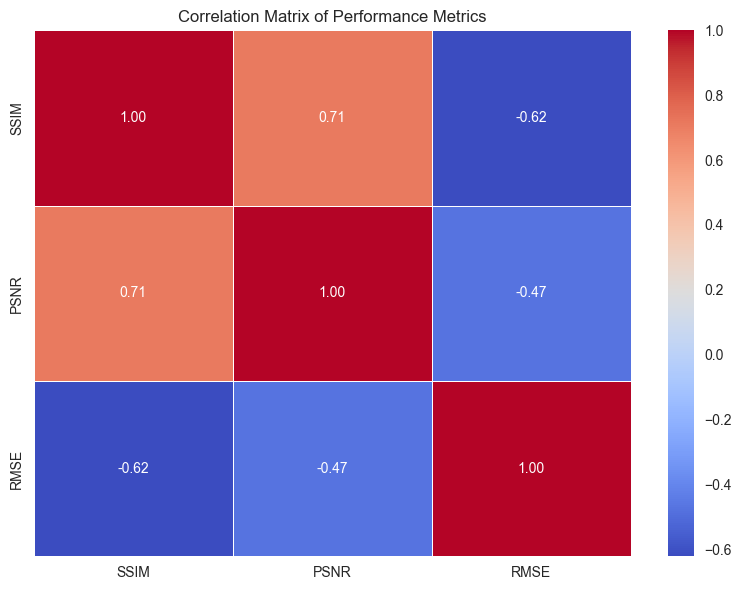

In [28]:
metrics_for_correlation = df_all[['SSIM', 'PSNR', 'RMSE']]
corr = metrics_for_correlation.corr()
display(corr)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Performance Metrics')
plt.tight_layout()
plt.savefig("figures/corr_heatmap.png", bbox_inches='tight', dpi=300)
plt.show()

## Analysis of Correlation Matrix and Heatmap

The correlation matrix and heatmap illustrate the pairwise relationships between the performance metrics (SSIM, PSNR, and RMSE).

*   **SSIM and PSNR:** A positive correlation coefficient of 0.71 indicates a moderately strong positive linear relationship between SSIM and PSNR. This suggests that algorithms that preserve structural details effectively (higher SSIM) also tend to minimize pixel-wise intensity differences (higher PSNR). While correlated, they are not perfectly collinear, implying they capture distinct yet related aspects of image quality.

*   **SSIM and RMSE:** A negative correlation coefficient of -0.62 is observed between SSIM and RMSE. This inverse relationship is expected, as a higher degree of structural similarity (higher SSIM) should correspond to a lower magnitude of error (lower RMSE).

*   **PSNR and RMSE:** A negative correlation coefficient of -0.47 is found between PSNR and RMSE. This relationship is anticipated given that PSNR is mathematically derived from the Mean Squared Error (MSE), where RMSE is the square root of MSE. Specifically, PSNR is inversely proportional to the logarithm of MSE. Therefore, as RMSE increases (higher error), MSE increases, and PSNR decreases. The observed negative correlation confirms this inverse relationship. The fact that the correlation is not a perfect -1.0 might be attributed to various factors such as the specific distribution of errors, the range of metric values in the dataset, or the sensitivity of each metric to different types of image degradation. Despite the mathematical link, the moderate nature of the correlation suggests that evaluating both metrics can provide a more complete understanding of an algorithm's error performance.

The correlation analysis confirms the expected relationships between the metrics and highlights that while SSIM, PSNR, and RMSE are related, they offer complementary insights into algorithm performance, each emphasizing different aspects of image quality and error.

# Pareto front analysis

Identify the Pareto optimal algorithms by considering SSIM, PSNR, and the inverse of RMSE. Mark these algorithms in the original dataframe and display the Pareto front.

In [29]:
import numpy as np
import pandas as pd

def pareto_front(df, metrics, maximize=None, eps=1e-9, return_mask=False):
    if maximize is None:
        maximize = [True] * len(metrics)
    if len(maximize) != len(metrics):
        raise ValueError("Length of 'maximize' must match length of 'metrics'.")

    # Extract objective matrix (n_points x n_objectives)
    X = df[metrics].to_numpy(dtype=float)
    n, m = X.shape
    if n == 0:
        if return_mask:
            return df.iloc[[]].copy(), np.array([], dtype=bool)
        return df.iloc[[]].copy()

    # Convert to "higher is better" by flipping columns that should be minimized
    for col_idx, do_max in enumerate(maximize):
        if not do_max:
            X[:, col_idx] = -X[:, col_idx]

    # Pareto mask initialization (assume all are Pareto until proven dominated)
    is_pareto = np.ones(n, dtype=bool)

    # Use a simple O(n^2) pairwise dominance check (works fine for n up to a few thousands)
    for i in range(n):
        if not is_pareto[i]:
            continue  # already dominated by some previously checked point
        xi = X[i]
        # compare i against all j (including j < i). If any j dominates i, mark i false.
        # We also mark j false when i dominates j to reduce comparisons (optional optimization)
        for j in range(n):
            if i == j or not is_pareto[j]:
                continue
            xj = X[j]
            # Check if j dominates i:
            # j >= i in all objectives (with eps), and strictly > in at least one (by > eps)
            if np.all(xj >= xi - eps) and np.any(xj > xi + eps):
                is_pareto[i] = False
                break
            # Conversely, check if i dominates j; if so, mark j not pareto to skip later
            if np.all(xi >= xj - eps) and np.any(xi > xj + eps):
                is_pareto[j] = False

    pareto_df = df.loc[is_pareto].copy()
    if return_mask:
        return pareto_df, is_pareto
    return pareto_df

In [30]:
pareto_df, mask = pareto_front(
        df_all,
        metrics=["SSIM", "PSNR", "RMSE"],
        maximize=[True, True, False],
        eps=1e-9,
        return_mask=True
    )

df_all["Pareto"] = mask
df_pareto = df_all[df_all["Pareto"] == True]
dfi.export(df_pareto, 'tables/pareto_table.png', table_conversion="matplotlib")
display(df_pareto)

,Algorithm,SSIM,PSNR,RMSE,Dataset,Family,SSIM_norm,PSNR_norm,RMSE_norm,Composite_Equal,Composite_Clinical,Pareto
1,redcnn+,0.9825,45.1584,0.0056,NBIA,CNN,0.974585,0.915535,1.000000,0.963373,0.961953,True
7,hcformer,0.8507,47.2800,0.0695,Mayo Clinic,Transformers,0.527957,1.000000,0.640809,0.722922,0.692140,True
18,noise2inverse,0.9900,45.0600,0.0056,Sinogram,Miscellaneous,1.000000,0.911617,1.000000,0.970539,0.973485,True


*   The Pareto optimal algorithms have been successfully identified from the dataset.
*   Two composite scores were calculated for the Pareto optimal algorithms: one with equal weighting for SSIM, PSNR, and inverse RMSE, and another with a clinical weighting prioritizing SSIM (50%), PSNR (30%), and inverse RMSE (20%).
*   Based on both equal and clinical weighting schemes, the 'noise2inverse' algorithm consistently ranked as the highest-performing Pareto optimal algorithm.
*   Under the clinical weighting, 'noise2inverse' achieved a composite score indicating a strong balance across the prioritized image quality metrics (SSIM: 0.9900, PSNR: 45.0600, RMSE: 0.0056).


# Decision logic and final analysis
Synthesize the analysis of different image restoration algorithms, focusing on algorithm comparison, identifying which algorithms work best and when to use them, and create a flowchart to visualize the decision-making process for algorithm selection.

In [45]:
from graphviz import Digraph
from IPython.display import Image

dot = Digraph('AlgorithmSelection', format='png')
dot.attr(rankdir='TB', splines='ortho')
dot.attr('node', shape='box', style='rounded,filled', fillcolor='white')

dot.node('A', 'Start: Identify Use Case & Prioritize Metrics')
dot.node('C', 'Focus on Families with Low Variability\n(e.g., Sinogram-based)')
dot.node('D', 'Consider All Families\nBased on Avg Performance')
dot.node('F', 'Consider Sinogram-based, Transformers, CNN Families')
dot.node('H', 'Consider Sinogram-based, Transformers, Diffusion Families')
dot.node('J', 'Consider Sinogram-based, CNN, Transformers Families')
dot.node('L', 'Consider Sinogram-based, Transformers, CNN Families')
dot.node('M', 'Evaluate Based on Specific Metric Needs')
dot.node('N', 'Narrow Down: Top Algorithms by SSIM & Pareto')
dot.node('O', 'Narrow Down: Top Algorithms by PSNR/RMSE & Pareto')
dot.node('P', 'Narrow Down: Top Algorithms by RMSE & Pareto')
dot.node('Q', 'Narrow Down: Top Algorithms by Composite & Pareto')
dot.node('R', 'Narrow Down: Specific Metric Analysis')
dot.node('S', 'Consider Dataset Relevance & Other Factors')
dot.node('Z', 'End: Select Algorithm')

dot.attr('node', shape='diamond', style='filled', fillcolor='lightgrey')
dot.node('B', 'Consistency Important?')
dot.node('E', 'Prioritize SSIM?')
dot.node('G', 'Prioritize PSNR?')
dot.node('I', 'Prioritize RMSE?')
dot.node('K', 'Prioritize Balance (Composite)?')

dot.edge('A', 'B')
dot.edge('B', 'C', label='Yes')
dot.edge('B', 'D', label='No')
dot.edge('C', 'E')
dot.edge('D', 'E')
dot.edge('E', 'F', label='Yes')
dot.edge('E', 'G', label='No')
dot.edge('G', 'H', label='Yes')
dot.edge('G', 'I', label='No')
dot.edge('I', 'J', label='Yes')
dot.edge('I', 'K', label='No')
dot.edge('K', 'L', label='Yes')
dot.edge('K', 'M', label='No')
dot.edge('F', 'N')
dot.edge('H', 'O')
dot.edge('J', 'P')
dot.edge('L', 'Q')
dot.edge('M', 'R')
dot.edge('N', 'S')
dot.edge('O', 'S')
dot.edge('P', 'S')
dot.edge('Q', 'S')
dot.edge('R', 'S')
dot.edge('C', 'S')
dot.edge('S', 'Z')

dot.render('figures/algo_flow', format='png', cleanup=True)

'figures/algo_flow.png'

The flowchart visually represents a decision-making process for selecting an image restoration algorithm based on the analysis of performance metrics and algorithm families. The logic used to construct this flowchart is as follows:

1.  **Start (Identify Use Case & Prioritize Metrics):** The process begins by defining the specific application for which the image restoration is needed. This step is crucial as it dictates which performance metrics are most important (e.g., is preserving fine details critical, or is minimizing overall noise the priority?).

2.  **Consistency Important?:** The first decision point considers whether the consistency of the algorithm's performance is a key factor. If consistent results are highly valued, the user is guided towards families known for lower variability, such as the "Miscellaneous" family, as identified in the statistical analysis.

3.  **Prioritize Specific Metrics (SSIM, PSNR, RMSE, Composite):** Subsequent decision points branch based on which specific performance metric or combination of metrics (composite score) is prioritized for the given use case.
    *   If **SSIM** is prioritized, the flowchart directs the user to consider algorithm families that performed well in preserving structural similarity (Misc, Transformers, CNN).
    *   If **PSNR** is prioritized, families with high average PSNR are recommended (Misc, Transformers, Diffusion).
    *   If **RMSE** is prioritized (and lower RMSE is better), families with low average RMSE are suggested (Misc, CNN, Transformers).
    *   If a **balance** across metrics (represented by the composite scores) is prioritized, families with high average composite scores are considered (Misc, Transformers, CNN).
    *   If none of the above metrics are the sole priority, a general evaluation based on specific needs is indicated.

4.  **Narrow Down Algorithms:** Based on the prioritized metrics and relevant algorithm families, the flowchart suggests narrowing down the selection. This involves examining:
    *   The top-performing individual algorithms for the prioritized metric(s) (as identified in the ranking analysis).
    *   The Pareto optimal algorithms, which represent efficient trade-offs between conflicting objectives (SSIM, PSNR, and inverse RMSE). These algorithms offer good overall performance across multiple metrics.

5.  **Consider Dataset Relevance & Other Factors:** Before making a final decision, it's essential to consider external factors not captured in the performance metrics alone. This includes evaluating whether the datasets used for evaluation are representative of the user's own data, as well as considering practical aspects like the computational resources required for the algorithm, its ease of implementation, and any specific constraints of the application.

6.  **End (Select Algorithm):** The final step is to select the algorithm that best aligns with the prioritized metrics, performs well based on the analysis, and is suitable considering other practical factors.

This structured approach helps guide users through the process of selecting an appropriate image restoration algorithm by systematically considering the performance analysis results and aligning them with the specific requirements of their task.